# Comparing plasticity rules

## For every model, meta-learn on 8-dimensional halfspace dataset, then transfer rules to a NEW instance, and train / test that on the same dataset type but with fixed rules.

Created by Basile Van Hoorick, Fall 2020.

In [10]:
%run FF_common.ipynb

## First, test original RNN as a sanity check.

In [11]:
# IMPORTANT: Henceforth, we use GD directly on inputs but use plasticity rules in the output and hidden layers.
opts_up = Options(gd_input=True,
                  use_graph_rule=True,
                  gd_graph_rule=True,
                  use_output_rule=True,
                  gd_output_rule=True,
                  gd_output=False)
opts_down = Options(gd_input=True,
                    use_graph_rule=True,
                    gd_graph_rule=False,  # Not meta-trainable anymore!
                    use_output_rule=True,
                    gd_output_rule=False,  # Not meta-trainable anymore!
                    gd_output=False)
scheme = UpdateScheme(cross_entropy_loss=True,
                      mse_loss=False,
                      update_misclassified_only=False,
                      update_all_edges=True)

# Feed-forward brain config.
n_up = 8  # Input layer size for meta-learning.
n_down = 8  # Input layer size for desired task training.
m = 2  # Output layer size.
l = 2  # Number of hidden layers.
w = 32  # Width of hidden layers.
p = 0.5  # Connectivity probability.
cap = 16  # Number of nodes firing per layer.

# Training config.
num_runs = 10
num_rule_epochs = 50
num_epochs_upstream = 1
num_epochs_downstream = 1
dataset = 'halfspace'

In [12]:
# Instantiate brain factories.
brain_rnn_up_fact = lambda: LocalNet(n_up, m, 64, p, 32, 2, options=opts_up, update_scheme=scheme)
brain_rnn_down_fact = lambda: LocalNet(n_down, m, 64, p, 32, 2, options=opts_down, update_scheme=scheme)

In [ ]:
# Evaluate model.
print('==== Original RNN (very different from all the rest) ====')
stats_rnn_up, stats_rnn_down = evaluate_up_down(
    brain_rnn_up_fact, brain_rnn_down_fact, n_up, n_down, dataset=dataset,
    num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)

  0%|          | 0/50 [00:00<?, ?it/s]

==== Original RNN (very different from all the rest) ====

Run 1 / 10...
Meta-learning...


In [ ]:
# Plot aggregated stats.
agg_stats_rnn_up = convert_multi_stats_uncertainty(stats_rnn_up)
agg_stats_rnn_down = convert_multi_stats_uncertainty(stats_rnn_down)
plot_curves(agg_stats_rnn_up, agg_stats_rnn_down,
            '[RNN] Upstream meta-learning on ' + dataset,
            '[RNN] Downstream training on ' + dataset,
            'figs/comparing_transfer_rnn_' + dataset)

## Evaluate all table-based feed-forward networks.

In [ ]:
# Instantiate brain factories.
brain_prepost_up_fact = lambda: FFLocalNet(
    n_up, m, l, w, p, cap, hl_rules=TableRule_PrePost(),
    output_rule=TableRule_PrePost(), options=opts_up, update_scheme=scheme)
brain_prepost_down_fact = lambda: FFLocalNet(
    n_down, m, l, w, p, cap, hl_rules=TableRule_PrePost(),
    output_rule=TableRule_PrePost(), options=opts_down, update_scheme=scheme)
brain_prepostcount_up_fact = lambda: FFLocalNet(
    n_up, m, l, w, p, cap, hl_rules=TableRule_PrePostCount(),
    output_rule=TableRule_PrePostCount(), options=opts_up, update_scheme=scheme)
brain_prepostcount_down_fact = lambda: FFLocalNet(
    n_down, m, l, w, p, cap, hl_rules=TableRule_PrePostCount(),
    output_rule=TableRule_PrePostCount(), options=opts_down, update_scheme=scheme)
brain_prepostpercent_up_fact = lambda: FFLocalNet(
    n_up, m, l, w, p, cap, hl_rules=TableRule_PrePostPercent(),
    output_rule=TableRule_PrePostPercent(), options=opts_up, update_scheme=scheme)
brain_prepostpercent_down_fact = lambda: FFLocalNet(
    n_down, m, l, w, p, cap, hl_rules=TableRule_PrePostPercent(),
    output_rule=TableRule_PrePostPercent(), options=opts_down, update_scheme=scheme)
brain_postcount_up_fact = lambda: FFLocalNet(
    n_up, m, l, w, p, cap, hl_rules=TableRule_PostCount(),
    output_rule=TableRule_PostCount(), options=opts_up, update_scheme=scheme)
brain_postcount_down_fact = lambda: FFLocalNet(
    n_down, m, l, w, p, cap, hl_rules=TableRule_PostCount(),
    output_rule=TableRule_PostCount(), options=opts_down, update_scheme=scheme)

In [ ]:
# Evaluate models.
print('==== Interpretation: Pre and Post ====')
stats_prepost_up, stats_prepost_down = evaluate_up_down(
    brain_prepost_up_fact, brain_prepost_down_fact, n_up, n_down, dataset=dataset,
    num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)
print('==== Interpretation: Pre and Post and Incoming Count ====')
stats_prepostcount_up, stats_prepostcount_down = evaluate_up_down(
    brain_prepostcount_up_fact, brain_prepostcount_down_fact, n_up, n_down, dataset=dataset,
    num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)
print('==== Interpretation: Pre and Post and Binned Incoming Fraction ====')
stats_prepostpercent_up, stats_prepostpercent_down = evaluate_up_down(
    brain_prepostpercent_up_fact, brain_prepostpercent_down_fact, n_up, n_down, dataset=dataset,
    num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)
print('==== Interpretation: Post and Incoming Count ====')
stats_postcount_up, stats_postcount_down = evaluate_up_down(
    brain_postcount_up_fact, brain_postcount_down_fact, n_up, n_down, dataset=dataset,
    num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)

In [ ]:
# Plot aggregated stats.
agg_stats_prepost_up = convert_multi_stats_uncertainty(stats_prepost_up)
agg_stats_prepost_down = convert_multi_stats_uncertainty(stats_prepost_down)
plot_curves(agg_stats_prepost_up, agg_stats_prepost_down,
            '[PrePost] Upstream meta-learning on ' + dataset,
            '[PrePost] Downstream training on ' + dataset,
            'figs/comparing_transfer_prepost_' + dataset)
agg_stats_prepostcount_up = convert_multi_stats_uncertainty(stats_prepostcount_up)
agg_stats_prepostcount_down = convert_multi_stats_uncertainty(stats_prepostcount_down)
plot_curves(agg_stats_prepostcount_up, agg_stats_prepostcount_down,
            '[PrePostCount] Upstream meta-learning on ' + dataset,
            '[PrePostCount] Downstream training on ' + dataset,
            'figs/comparing_transfer_prepostcount_' + dataset)
agg_stats_prepostpercent_up = convert_multi_stats_uncertainty(stats_prepostpercent_up)
agg_stats_prepostpercent_down = convert_multi_stats_uncertainty(stats_prepostpercent_down)
plot_curves(agg_stats_prepostpercent_up, agg_stats_prepostpercent_down,
            '[PrePostPercent] Upstream meta-learning on ' + dataset,
            '[PrePostPercent] Downstream training on ' + dataset,
            'figs/comparing_transfer_prepostpercent_' + dataset)
agg_stats_postcount_up = convert_multi_stats_uncertainty(stats_postcount_up)
agg_stats_postcount_down = convert_multi_stats_uncertainty(stats_postcount_down)
plot_curves(agg_stats_postcount_up, agg_stats_postcount_down,
            '[PostCount] Upstream meta-learning on ' + dataset,
            '[PostCount] Downstream training on ' + dataset,
            'figs/comparing_transfer_postcount_' + dataset)

In [ ]:
# Plot to compare all.
all_stats_up = [agg_stats_rnn_up, agg_stats_prepost_up, agg_stats_prepostcount_up, agg_stats_prepostpercent_up, agg_stats_postcount_up]
all_stats_down = [agg_stats_rnn_down, agg_stats_prepost_down, agg_stats_prepostcount_down, agg_stats_prepostpercent_down, agg_stats_postcount_down]
labels = ['RNN', 'PrePost', 'PrePostCount', 'PrePostPercent', 'PostCount']
plot_compare_models(all_stats_up, all_stats_down, labels,
                    'Upstream meta-learning on ' + dataset,
                    'Downstream training on ' + dataset,
                    'figs/comparing_transfer_table_' + dataset)

In [ ]:
if 0:
    agg_stats_prepost_up = convert_multi_stats_uncertainty(stats_prepost_up)
    agg_stats_prepost_down = convert_multi_stats_uncertainty(stats_prepost_down)
    for i in range(len(stats_prepost_up)):
        plot_curves(stats_prepost_up[i], stats_prepost_down[i],
                    '[PrePost] Upstream meta-learning on ' + dataset,
                    '[PrePost] Downstream training on ' + dataset)

## Similarly, evaluate RNN and table-based networks but retain the SAME instance upstream and downstream; only the dataset is reinstantiated.

In [ ]:
# IMPORTANT: Henceforth, we use GD directly on inputs but use plasticity rules in the output and hidden layers.
opts = Options(gd_input=True,
               use_graph_rule=True,
               gd_graph_rule=True,
               use_output_rule=True,
               gd_output_rule=True,
               gd_output=False)
scheme = UpdateScheme(cross_entropy_loss=True,
                      mse_loss=False,
                      update_misclassified_only=False,
                      update_all_edges=True)

# Feed-forward brain config.
# See start of notebook.
n = 8

# Training config.
# See start of notebook.

In [ ]:
# Instantiate brain factories.
brain_rnn_fact = lambda: LocalNet(n_up, m, 64, p, 32, 3, options=opts, update_scheme=scheme)
brain_prepost_fact = lambda: FFLocalNet(
    n, m, l, w, p, cap, hl_rules=TableRule_PrePost(),
    output_rule=TableRule_PrePost(), options=opts, update_scheme=scheme)
brain_prepostcount_fact = lambda: FFLocalNet(
    n, m, l, w, p, cap, hl_rules=TableRule_PrePostCount(),
    output_rule=TableRule_PrePostCount(), options=opts, update_scheme=scheme)
brain_prepostpercent_fact = lambda: FFLocalNet(
    n, m, l, w, p, cap, hl_rules=TableRule_PrePostPercent(),
    output_rule=TableRule_PrePostPercent(), options=opts, update_scheme=scheme)
brain_postcount_fact = lambda: FFLocalNet(
    n, m, l, w, p, cap, hl_rules=TableRule_PostCount(),
    output_rule=TableRule_PostCount(), options=opts, update_scheme=scheme)

In [ ]:
# Evaluate models.
print('==== Original RNN (very different from all the rest) ====')
stats_rnn_up, stats_rnn_down = evaluate_brain(
    brain_rnn_fact, n, dataset=dataset,
    num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)
print('==== Interpretation: Pre and Post ====')
stats_prepost_up, stats_prepost_down = evaluate_brain(
    brain_prepost_fact, n, dataset=dataset,
    num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)
print('==== Interpretation: Pre and Post and Incoming Count ====')
stats_prepostcount_up, stats_prepostcount_down = evaluate_brain(
    brain_prepostcount_fact, n, dataset=dataset,
    num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)
print('==== Interpretation: Pre and Post and Binned Incoming Fraction ====')
stats_prepostpercent_up, stats_prepostpercent_down = evaluate_brain(
    brain_prepostpercent_fact, n, dataset=dataset,
    num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)
print('==== Interpretation: Post and Incoming Count ====')
stats_postcount_up, stats_postcount_down = evaluate_brain(
    brain_postcount_fact, n, dataset=dataset,
    num_runs=num_runs, num_rule_epochs=num_rule_epochs,
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream)

In [ ]:
# Plot aggregated stats.
agg_stats_rnn_up = convert_multi_stats_uncertainty(stats_rnn_up)
agg_stats_rnn_down = convert_multi_stats_uncertainty(stats_rnn_down)
plot_curves(agg_stats_rnn_up, agg_stats_rnn_down,
            '[RNN] Upstream meta-learning on ' + dataset,
            '[RNN] Downstream training on ' + dataset,
            'figs/comparing_single_rnn_' + dataset)
agg_stats_prepost_up = convert_multi_stats_uncertainty(stats_prepost_up)
agg_stats_prepost_down = convert_multi_stats_uncertainty(stats_prepost_down)
plot_curves(agg_stats_prepost_up, agg_stats_prepost_down,
            '[PrePost] Upstream meta-learning on ' + dataset,
            '[PrePost] Downstream training on ' + dataset,
            'figs/comparing_single_prepost_' + dataset)
agg_stats_prepostcount_up = convert_multi_stats_uncertainty(stats_prepostcount_up)
agg_stats_prepostcount_down = convert_multi_stats_uncertainty(stats_prepostcount_down)
plot_curves(agg_stats_prepostcount_up, agg_stats_prepostcount_down,
            '[PrePostCount] Upstream meta-learning on ' + dataset,
            '[PrePostCount] Downstream training on ' + dataset,
            'figs/comparing_single_prepostcount_' + dataset)
agg_stats_prepostpercent_up = convert_multi_stats_uncertainty(stats_prepostpercent_up)
agg_stats_prepostpercent_down = convert_multi_stats_uncertainty(stats_prepostpercent_down)
plot_curves(agg_stats_prepostpercent_up, agg_stats_prepostpercent_down,
            '[PrePostPercent] Upstream meta-learning on ' + dataset,
            '[PrePostPercent] Downstream training on ' + dataset,
            'figs/comparing_single_prepostpercent_' + dataset)
agg_stats_postcount_up = convert_multi_stats_uncertainty(stats_postcount_up)
agg_stats_postcount_down = convert_multi_stats_uncertainty(stats_postcount_down)
plot_curves(agg_stats_postcount_up, agg_stats_postcount_down,
            '[PostCount] Upstream meta-learning on ' + dataset,
            '[PostCount] Downstream training on ' + dataset,
            'figs/comparing_single_postcount_' + dataset)

Saving figure to: figs/comparing_single_table_halfspace


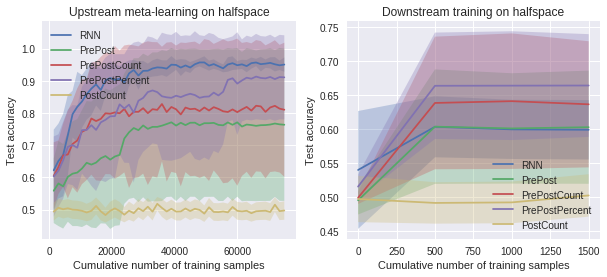

In [25]:
# Plot to compare all.
all_stats_up = [agg_stats_rnn_up, agg_stats_prepost_up, agg_stats_prepostcount_up, agg_stats_prepostpercent_up, agg_stats_postcount_up]
all_stats_down = [agg_stats_rnn_down, agg_stats_prepost_down, agg_stats_prepostcount_down, agg_stats_prepostpercent_down, agg_stats_postcount_down]
labels = ['RNN', 'PrePost', 'PrePostCount', 'PrePostPercent', 'PostCount']
plot_compare_models(all_stats_up, all_stats_down, labels,
                    'Upstream meta-learning on ' + dataset,
                    'Downstream training on ' + dataset,
                    'figs/comparing_single_table_' + dataset)

## Evaluate all small-ANN-based feed-forward networks.